In [1]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import RESULTS_DIR
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import MOOD_BASELINES
from mood.utils import get_outlier_bounds
from mood.metrics import Metric

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SUBDIR = "20230225"

In [3]:
in_dir = dm.fs.join(RESULTS_DIR, "dataframes", "compare_performance", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [4]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, MOOD_BASELINES, MOOD_REPRESENTATIONS))
assert len(list(all_triplets)) == len(paths), find_missing(paths, all_triplets)

In [5]:
df_original = pd.concat(dm.utils.parallelized(pd.read_csv, paths, progress=True), ignore_index=True)

  0%|                                                                                                                                              | 0/198 [00:00<?, ?it/s]/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:05<00:00, 39.08it/s]


In [6]:
# Some models learn to predict a constant function. This results in a NaN pearson score.
# We replace this by zeroes to still include them in our analysis
mask = pd.isna(df_original).any(axis=1) & (df_original["metric"] == "Pearson")
df_original.loc[mask, "score_mu"] = 0
df_original.loc[mask, "score_std"] = 0

In [7]:
df_original.groupby(["type", "metric"])[["iid_score", "ood_score"]].describe()

iid_score                                            \
                            count       mean        std       min       25%   
type        metric                                                            
calibration Brier score     108.0   0.255329   0.126491  0.031284  0.159110   
            Pearson          90.0   0.205355   0.173324 -0.096103  0.056223   
performance AUROC           108.0   0.756865   0.069704  0.497817  0.723545   
            MAE              90.0  13.984769  14.101508  0.307306  0.643093   

                                                        ood_score             \
                              50%        75%        max     count       mean   
type        metric                                                             
calibration Brier score  0.244460   0.347215   0.564521     108.0   0.266476   
            Pearson      0.187466   0.326417   0.728321      90.0   0.164575   
performance AUROC        0.760542   0.803462   0.887637     108.0   0.723527   
            MAE          9.951732  22.796925  41.027370      90.0  15.353976   

                                                                              \
                               std       min       25%        50%        75%   
type        metric                                                             
calibration Brier score   0.142968  0.028095  0.154216   0.251478   0.364780   
            Pearson       0.172487 -0.086227  0.035639   0.139857   0.253968   
performance AUROC         0.066413  0.498824  0.694732   0.729973   0.760344   
            MAE          15.235283  0.311015  0.753443  11.320117  27.190148   

                                    
                               max  
type        metric                  
calibration Brier score   0.699812  
            Pearson       0.734990  
performance AUROC         0.876457  
            MAE          42.866581

In [8]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# Upscale the Pearson correlation to go from [-1, 1] to [0, 1]
df.loc[df["metric"] == "Pearson", "iid_score"] = (df["iid_score"] + 1) / 2
df.loc[df["metric"] == "Pearson", "ood_score"] = (df["ood_score"] + 1) / 2

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

# Invert the gap of metrics that need to be minimized, so that a high gap is always better
df["metric_direction"] = df["metric"].apply(lambda x: Metric.by_name(x).mode)
df.loc[df["gap"] == "min", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "min", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,score_mu,score_std,gap,relative_gap,metric_direction
0,BBB,GP,ChemBERTa,0.777683,0.703392,AUROC,performance,NaN,NaN,-0.074291,-9.552875,max
1,BBB,GP,ChemBERTa,0.170960,0.164108,Brier score,calibration,NaN,NaN,-0.006852,4.008094,min
2,BBB,GP,Desc2D,0.777883,0.779799,AUROC,performance,NaN,NaN,0.001916,0.246347,max
3,BBB,GP,Desc2D,0.137008,0.146016,Brier score,calibration,NaN,NaN,0.009008,-6.574931,min
4,BBB,GP,ECFP6,0.782923,0.610287,AUROC,performance,NaN,NaN,-0.172636,-22.050209,max


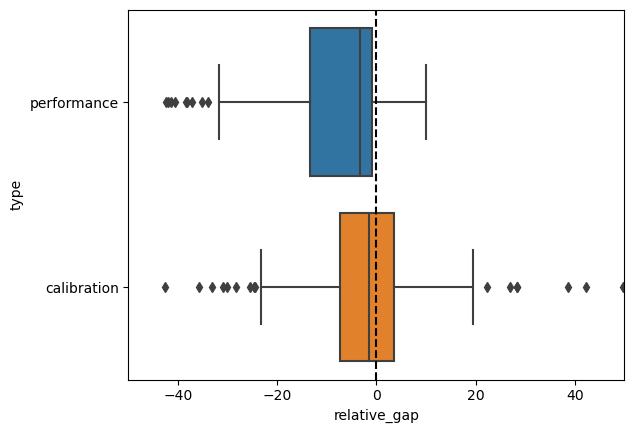

In [9]:
ax = sns.boxplot(data=df, x="relative_gap", y="type")
ax.set_xlim([-50, 50])
ax.plot([0, 0], ax.get_ylim(), "k--")

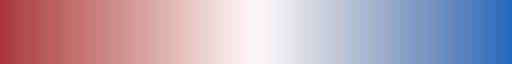

In [10]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
cmap

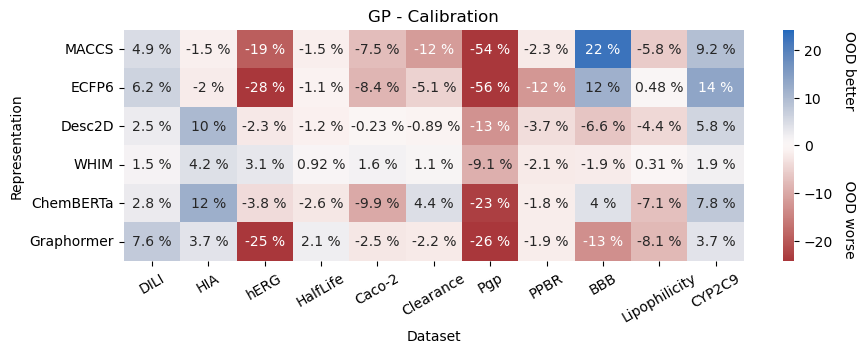

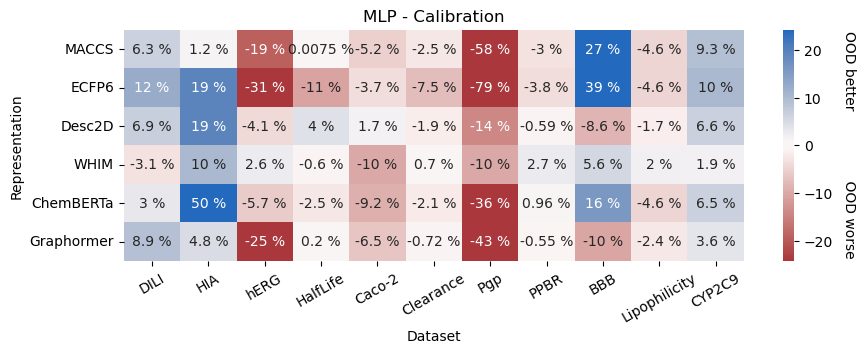

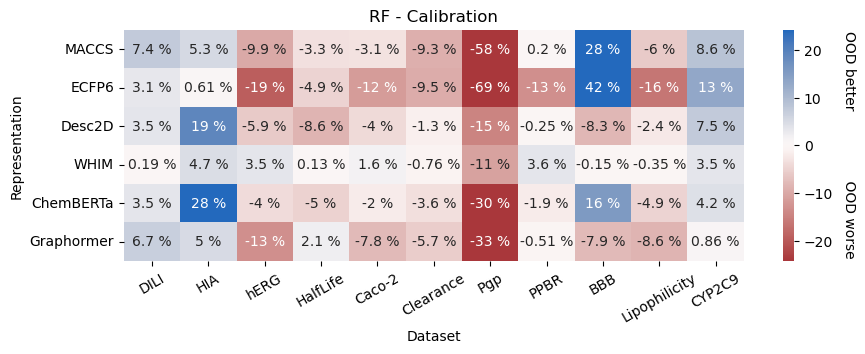

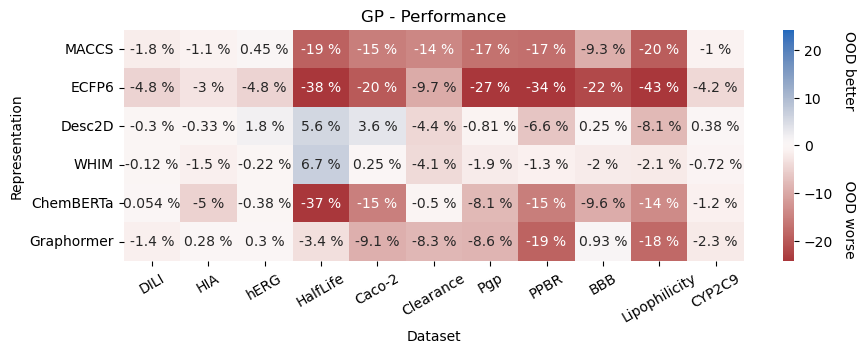

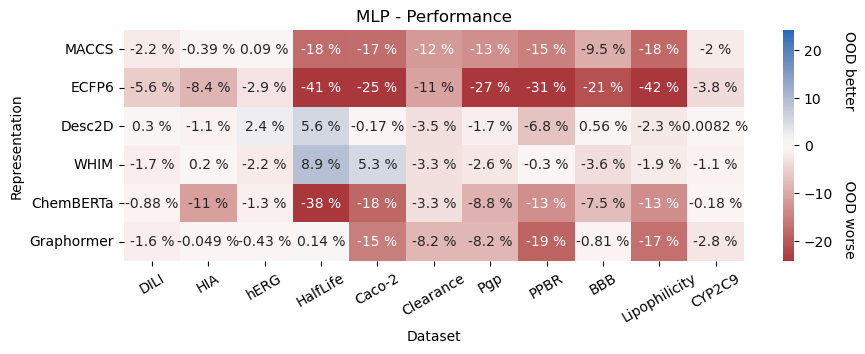

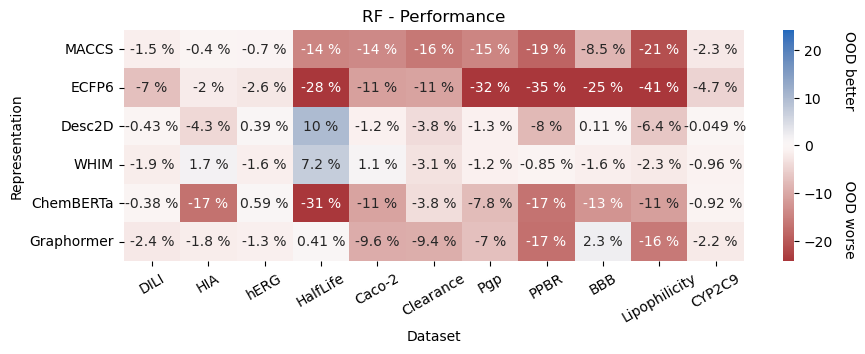

In [11]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        pivot = pivot.reindex(MOOD_REPRESENTATIONS)
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(f"{name} - {metric_type.capitalize()}")
        ax.text(
            0.85, 
            0.5, 
            f"{'OOD better':25} OOD worse", 
            rotation=-90, 
            ha="center", 
            va="center", 
            transform=fig.transFigure
        )

# Condensed
This is meant to condense the information in a smaller, easier to read plot suited for publications

In [12]:
c1 = df.groupby(["Dataset", "Representation", "metric", "type", "metric_direction"]).std()["relative_gap"]
c2 = df.groupby(["Dataset", "Representation", "metric", "type", "metric_direction"]).mean()["relative_gap"]
data = pd.DataFrame({"std": c1, "mean": c2}).reset_index()
data.head()

,Dataset,Representation,metric,type,metric_direction,std,mean
0,BBB,ChemBERTa,AUROC,performance,max,2.562949,-9.899384
1,BBB,ChemBERTa,Brier score,calibration,min,6.750602,11.800046
2,BBB,Desc2D,AUROC,performance,max,0.229399,0.304819
3,BBB,Desc2D,Brier score,calibration,min,1.085459,-7.817215
4,BBB,ECFP6,AUROC,performance,max,1.763425,-22.595142


In [13]:
data[data["Dataset"] == "HIA"]

,Dataset,Representation,metric,type,metric_direction,std,mean
60,HIA,ChemBERTa,AUROC,performance,max,5.967785,-11.016584
61,HIA,ChemBERTa,Brier score,calibration,min,19.023243,29.924798
62,HIA,Desc2D,AUROC,performance,max,2.131181,-1.928469
63,HIA,Desc2D,Brier score,calibration,min,5.263269,16.194191
64,HIA,ECFP6,AUROC,performance,max,3.469381,-4.480726
65,HIA,ECFP6,Brier score,calibration,min,11.717909,6.034683
66,HIA,Graphormer,AUROC,performance,max,1.103044,-0.513073
67,HIA,Graphormer,Brier score,calibration,min,0.686650,4.514435
68,HIA,MACCS,AUROC,performance,max,0.425428,-0.639517
69,HIA,MACCS,Brier score,calibration,min,3.400181,1.676411


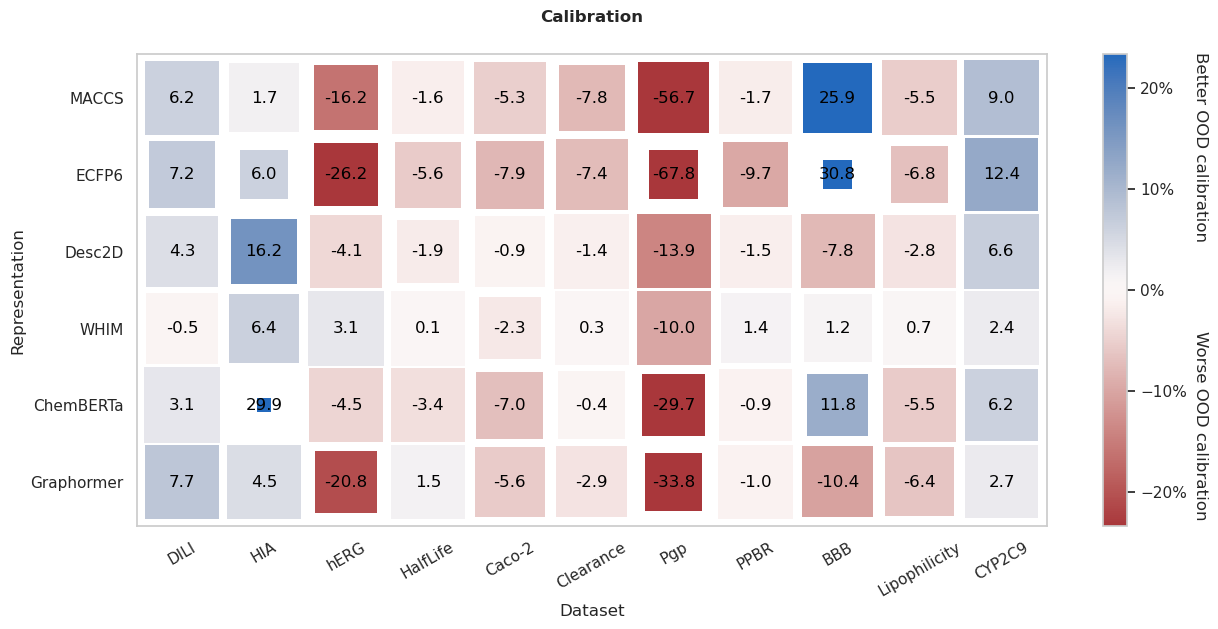

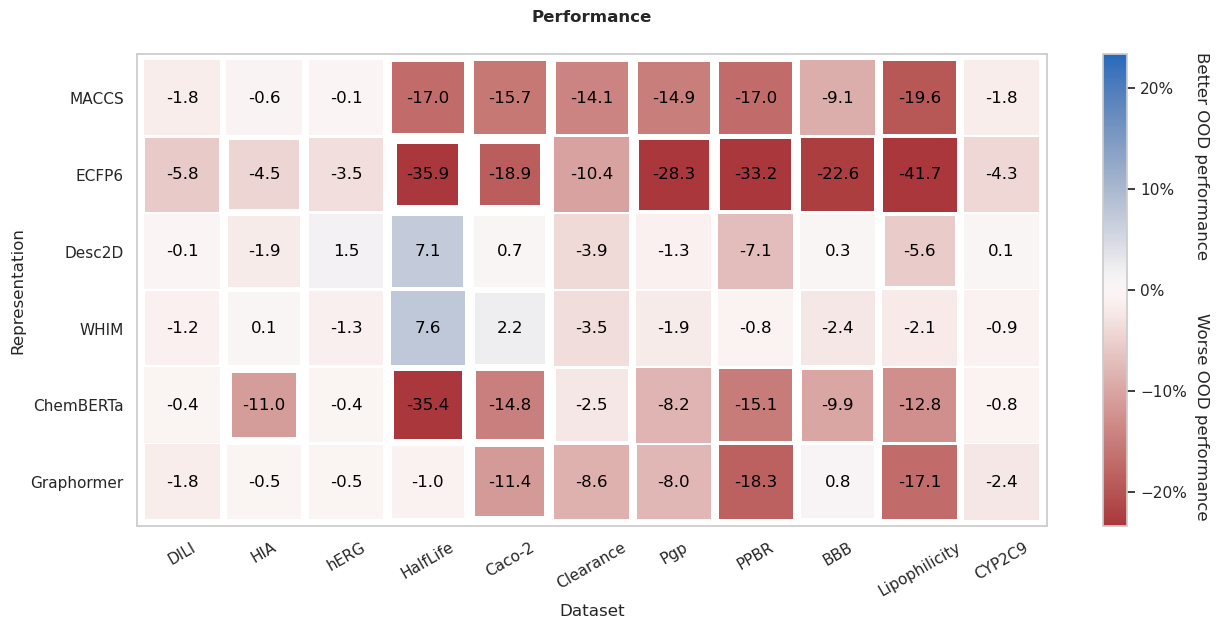

In [14]:
sns.set(style="whitegrid")

scale_vmax = data["std"].max()

lower, upper = get_outlier_bounds(data["mean"].to_numpy())
hue_vmin = min(lower, -upper)
hue_vmax = -hue_vmin

for metric_type, metric_group in data.groupby("type"):
    
    metric_group = metric_group.sort_values(
        by=["Dataset", "Representation"], 
        key=lambda x: [MOOD_DATASETS.index(x_) if x_ in MOOD_DATASETS else len(MOOD_REPRESENTATIONS) - MOOD_REPRESENTATIONS.index(x_) for x_ in x]
    )

    g = sns.relplot(
        x="Dataset", 
        y="Representation",
        hue="mean", 
        size="std",
        hue_norm=(hue_vmin, hue_vmax), 
        size_norm=(0, scale_vmax),
        palette="vlag_r", 
        sizes=(3000, 100),
        marker="s", 
        linewidth=0, 
        legend=False, 
        aspect=2, 
        height=6.5, 
        data=metric_group,
    )
    g.ax.invert_yaxis()
    ghost = g.ax.scatter([], [], c=[], vmin=hue_vmin, vmax=hue_vmax, cmap="vlag_r")
    cbar = g.fig.colorbar(ghost)
    cbar.ax.set_yticklabels([f"{label.get_text()}%" for label in cbar.ax.get_yticklabels()])
    
    g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=30, ha="center")
    g.ax.set_title(metric_type.capitalize(), fontweight="bold", y=1.05)
    g.ax.text(
        .93, 
        0.9, 
        f"Better OOD {metric_type}", 
        rotation=-90, 
        ha="center", 
        va="top", 
        transform=g.fig.transFigure
    )
    
    g.ax.text(
        .93, 
        0.18, 
        f"Worse OOD {metric_type}", 
        rotation=-90, 
        ha="center", 
        va="bottom", 
        transform=g.fig.transFigure
    )
    g.ax.grid()
    plt.tight_layout()
    
    g.ax.spines["top"].set_visible(True)
    g.ax.spines["right"].set_visible(True)
    
    lim = g.ax.get_ylim()
    g.ax.set_ylim(lim[0] - 0.325, lim[1] + 0.325)
    
    lim = g.ax.get_xlim()
    g.ax.set_xlim(lim[0] - 0.05, lim[1] + 0.05)
    
    for x in g.ax.get_xticks():
        for y in g.ax.get_yticks():
            representation = g.ax.get_yticklabels()[y].get_text()
            dataset = g.ax.get_xticklabels()[x].get_text()
            row = metric_group[(metric_group["Dataset"] == dataset) & (metric_group["Representation"] == representation)]
            score = row["mean"].item()
            size = row["std"].item()
            c = "black"
            g.ax.text(x, y, f"{score:.1f}", ha="center", va="center", fontsize=12, color=c)

The End.